In [61]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from helper_functions import cyclical_encoder, xy_rnn_split
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader


## Setup Device Agnostic Code

In [62]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Reading the data

In [63]:
train = pd.read_excel("data\Train.xlsx")
test = pd.read_excel("data\Test.xlsx")

In [64]:
train.head(10)

,Tahun,Bulan,HKD
0,2001,January,"1,211.66"
1,2001,February,"1,260.97"
2,2001,March,"1,333.49"
3,2001,April,"1,496.93"
4,2001,May,"1,417.82"
5,2001,June,"1,466.74"
6,2001,July,"1,221.24"
7,2001,August,"1,136.58"
8,2001,September,"1,240.44"
9,2001,October,"1,337.83"


In [65]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264 entries, 0 to 263
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Tahun   264 non-null    int64 
 1   Bulan   264 non-null    object
 2   HKD     264 non-null    object
dtypes: int64(1), object(2)
memory usage: 6.3+ KB


In [66]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Tahun   12 non-null     int64 
 1   Bulan   12 non-null     object
 2   HKD     12 non-null     object
dtypes: int64(1), object(2)
memory usage: 416.0+ bytes


In [67]:
train.describe()

,Tahun
count,264.000000
mean,2011.500000
std,6.356339
min,2001.000000
25%,2006.000000
50%,2011.500000
75%,2017.000000
max,2022.000000


Skewness of HKD (scipy): 0.777799091548617


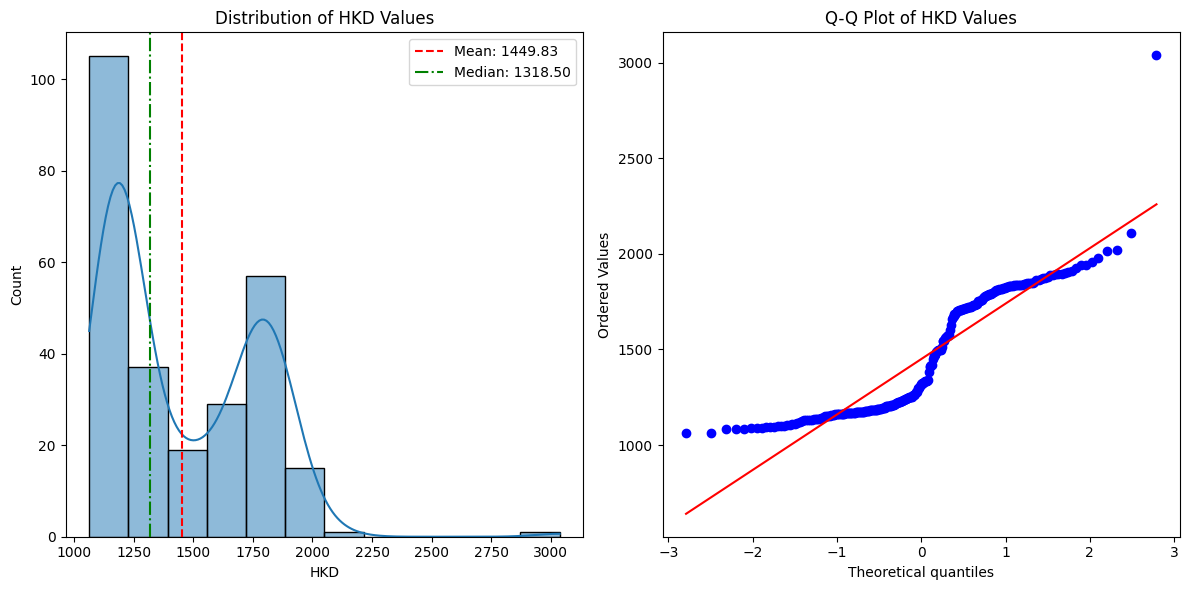

In [68]:
# Convert 'HKD' column to numeric values
train['HKD'] = train['HKD'].str.replace(',', '').astype(float)
test['HKD'] = test['HKD'].str.replace(',', '').astype(float)

skewness_scipy = stats.skew(train['HKD'])
print(f"Skewness of HKD (scipy): {skewness_scipy}")

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.histplot(train['HKD'], kde=True)
plt.title('Distribution of HKD Values')
plt.axvline(train['HKD'].mean(), color='r', linestyle='--', label=f'Mean: {train["HKD"].mean():.2f}')
plt.axvline(train['HKD'].median(), color='g', linestyle='-.', label=f'Median: {train["HKD"].median():.2f}')
plt.legend()

plt.subplot(1, 2, 2)
stats.probplot(train['HKD'], plot=plt)
plt.title('Q-Q Plot of HKD Values')

plt.tight_layout()
plt.show()

## Data Preprocessing

Sebelum melakukan memasukkan data ke dalam model, kita harus mempreproses datanya terlebih dahulu, berikut adalah langkah-langkah yang saya ambil:
1. Melakukan `Log Transformation` pada fitur `HKD`. Dilakukan untuk mengurus Skewness pada data.
2. Melakukan `Scaling` pada fitur `HKD`. Hal ini dilakukan untuk menyamakan skala dan membuat model belajar lebih baik.
3. Melakukan `Encoding` pada fitur `Bulan`. Hal ini dilakukan untuk mengubah format data yang awalnya categorical menjadi numeric agar model dapat memprosesnya lebih baik.

**NOTE**: Tidak perlu memeriksa missing values, karena ini adalah data yang sudah di olah sebelumnya

In [69]:
# Menyalin data untuk dilakukan preprocessing
train_preprocessed = train.copy()
test_preprocessed = test.copy()

Original skewness of HKD: 0.7778
Skewness after log transformation: 0.4004


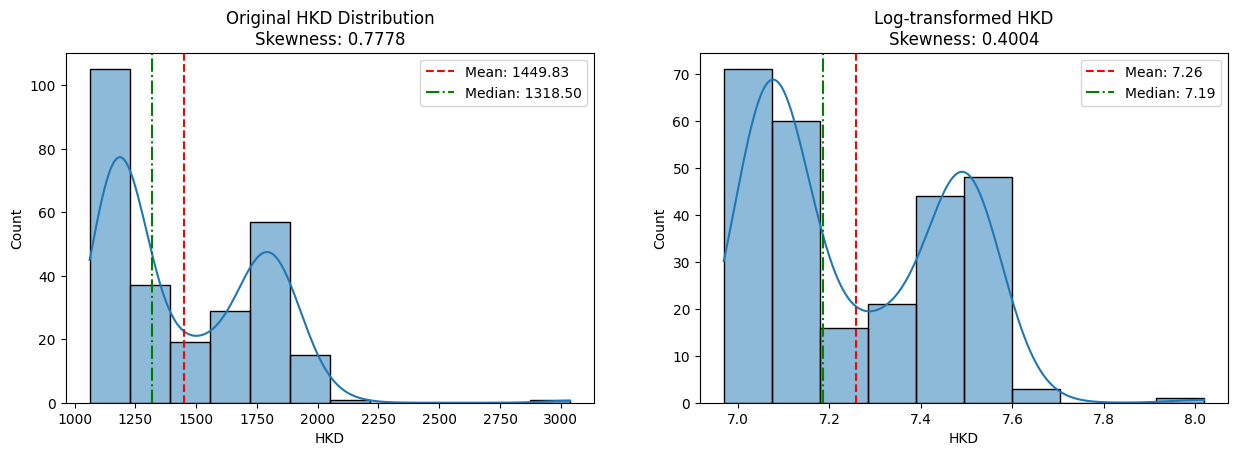

In [70]:
# Apply log transformation
train_preprocessed['HKD'] = np.log1p(train['HKD'])
test_preprocessed['HKD'] = np.log1p(test['HKD'])

# Check original skewness
print(f"Original skewness of HKD: {skewness_scipy:.4f}")

# Check skewness after log transformation
log_skewness = stats.skew(train_preprocessed['HKD'])
print(f"Skewness after log transformation: {log_skewness:.4f}")

# Visualize the original and transformed distributions
plt.figure(figsize=(15, 10))

# Original distribution
plt.subplot(2, 2, 1)
sns.histplot(train['HKD'], kde=True)
plt.title(f'Original HKD Distribution\nSkewness: {skewness_scipy:.4f}')
plt.axvline(train['HKD'].mean(), color='r', linestyle='--', label=f'Mean: {train["HKD"].mean():.2f}')
plt.axvline(train['HKD'].median(), color='g', linestyle='-.', label=f'Median: {train["HKD"].median():.2f}')
plt.legend()

# Log-transformed distribution
plt.subplot(2, 2, 2)
sns.histplot(train_preprocessed['HKD'], kde=True)
plt.title(f'Log-transformed HKD\nSkewness: {log_skewness:.4f}')
plt.axvline(train_preprocessed['HKD'].mean(), color='r', linestyle='--', label=f'Mean: {train_preprocessed["HKD"].mean():.2f}')
plt.axvline(train_preprocessed['HKD'].median(), color='g', linestyle='-.', label=f'Median: {train_preprocessed["HKD"].median():.2f}')
plt.legend()


In [71]:
train_preprocessed = cyclical_encoder(train_preprocessed, col_name="Bulan", period=12)
test_preprocessed = cyclical_encoder(test_preprocessed, col_name="Bulan", period=12)

train_preprocessed.head()

,Tahun,Bulan,HKD,Bulan_sin,Bulan_cos
0,2001,1,7.100572,0.500000,8.660254e-01
1,2001,2,7.140429,0.866025,5.000000e-01
2,2001,3,7.196304,1.000000,6.123234e-17
3,2001,4,7.311839,0.866025,-5.000000e-01
4,2001,5,7.257581,0.500000,-8.660254e-01


In [72]:
scaler = StandardScaler()
scaler_target = StandardScaler()
scale_features = ['Bulan_sin', 'Bulan_cos']
scale_target = 'HKD'

train_preprocessed[scale_features] = scaler.fit_transform(train_preprocessed[scale_features])
test_preprocessed[scale_features] = scaler.transform(test_preprocessed[scale_features])

train_preprocessed[scale_target] = scaler_target.fit_transform(train_preprocessed[[scale_target]])
test_preprocessed[scale_target] = scaler_target.transform(test_preprocessed[[scale_target]])

print(train_preprocessed.head())
print(test_preprocessed.head())

   Tahun  Bulan       HKD  Bulan_sin     Bulan_cos
0   2001      1 -0.765426   0.707107  1.224745e+00
1   2001      2 -0.571862   1.224745  7.071068e-01
2   2001      3 -0.300510   1.414214  1.508267e-16
3   2001      4  0.260572   1.224745 -7.071068e-01
4   2001      5 -0.002929   0.707107 -1.224745e+00
   Tahun  Bulan       HKD  Bulan_sin     Bulan_cos
0   2023      1  1.448389   0.707107  1.224745e+00
1   2023      2  1.536438   1.224745  7.071068e-01
2   2023      3  1.466127   1.414214  1.508267e-16
3   2023      4  1.363883   1.224745 -7.071068e-01
4   2023      5  1.445849   0.707107 -1.224745e+00


In [73]:
train_preprocessed = train_preprocessed.sort_values(by=["Tahun", "Bulan"])

SEQUENCE_LENGTH = 3

X_train, y_train = xy_rnn_split(train_preprocessed, target_col='HKD', time_steps=SEQUENCE_LENGTH)
X_val, y_val = xy_rnn_split(test_preprocessed, target_col='HKD', time_steps=SEQUENCE_LENGTH)

    
# Convert to PyTorch tensors
X_train = torch.Tensor(X_train)
X_val = torch.Tensor(X_val)
y_train = torch.Tensor(y_train)
y_val = torch.Tensor(y_val)

X_train, y_train = X_train.to(device), y_train.to(device)
X_val, y_val = X_val.to(device), y_val.to(device)

# Create TensorDatasets
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)

# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

X_train.shape, y_train.shape, X_val.shape, y_val.shape

(torch.Size([261, 3, 4]),
 torch.Size([261, 1]),
 torch.Size([9, 3, 4]),
 torch.Size([9, 1]))

## Modeling RNN

In [74]:
# Define the RNN model
class MonetaryRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MonetaryRNN, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x, hidden=None):
        # Initialize hidden state with zeros if not provided
        if hidden is None:
            hidden = torch.zeros(1, x.size(0), self.hidden_size, device=x.device)
        
        # Process input through RNN
        output, hidden = self.rnn(x, hidden)
        
        # Use output from last time step for classification/regression
        output = self.fc(output[:, -1, :])
        return output, hidden

In [75]:
INPUT_SIZE = X_train.shape[2]
HIDDEN_SIZE = 128
OUTPUT_SIZE = 1

model_0 = MonetaryRNN(INPUT_SIZE, HIDDEN_SIZE, OUTPUT_SIZE)
model_0 = model_0.to(device)

model_0

MonetaryRNN(
  (rnn): RNN(4, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

In [76]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model_0.parameters(), lr=0.001)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [1/20], Train Loss: 1.3502, Val Loss: 3.4106, RMSE: 1.8468, MAE: 1.8436, R²: -286.8542
Model saved at epoch 1


 20%|██        | 4/20 [00:00<00:00, 30.14it/s]

Epoch [2/20], Train Loss: 0.8569, Val Loss: 1.8433, RMSE: 1.3577, MAE: 1.3533, R²: -154.5776
Model saved at epoch 2
Epoch [3/20], Train Loss: 1.0493, Val Loss: 1.4508, RMSE: 1.2045, MAE: 1.1996, R²: -121.4516
Model saved at epoch 3
Epoch [4/20], Train Loss: 1.1771, Val Loss: 1.5836, RMSE: 1.2584, MAE: 1.2537, R²: -132.6565
Epoch [5/20], Train Loss: 1.1547, Val Loss: 1.8339, RMSE: 1.3542, MAE: 1.3498, R²: -153.7778
Epoch [6/20], Train Loss: 1.1033, Val Loss: 1.9768, RMSE: 1.4060, MAE: 1.4018, R²: -165.8381


 40%|████      | 8/20 [00:00<00:00, 30.22it/s]

Epoch [7/20], Train Loss: 1.0713, Val Loss: 1.9831, RMSE: 1.4082, MAE: 1.4040, R²: -166.3714
Epoch [8/20], Train Loss: 1.0631, Val Loss: 1.9314, RMSE: 1.3898, MAE: 1.3855, R²: -162.0144


 60%|██████    | 12/20 [00:00<00:00, 31.73it/s]

Epoch [9/20], Train Loss: 1.0695, Val Loss: 1.8901, RMSE: 1.3748, MAE: 1.3705, R²: -158.5272
Epoch [10/20], Train Loss: 1.0778, Val Loss: 1.8786, RMSE: 1.3706, MAE: 1.3663, R²: -157.5527
Epoch [11/20], Train Loss: 1.0814, Val Loss: 1.8857, RMSE: 1.3732, MAE: 1.3689, R²: -158.1557
Epoch [12/20], Train Loss: 1.0810, Val Loss: 1.8956, RMSE: 1.3768, MAE: 1.3725, R²: -158.9907
Epoch [13/20], Train Loss: 1.0793, Val Loss: 1.9003, RMSE: 1.3785, MAE: 1.3742, R²: -159.3870
Epoch [14/20], Train Loss: 1.0782, Val Loss: 1.9000, RMSE: 1.3784, MAE: 1.3741, R²: -159.3595
Epoch [15/20], Train Loss: 1.0780, Val Loss: 1.8979, RMSE: 1.3776, MAE: 1.3733, R²: -159.1824


 85%|████████▌ | 17/20 [00:00<00:00, 30.78it/s]

Epoch [16/20], Train Loss: 1.0783, Val Loss: 1.8964, RMSE: 1.3771, MAE: 1.3728, R²: -159.0572
Epoch [17/20], Train Loss: 1.0787, Val Loss: 1.8961, RMSE: 1.3770, MAE: 1.3727, R²: -159.0296
Epoch [18/20], Train Loss: 1.0788, Val Loss: 1.8964, RMSE: 1.3771, MAE: 1.3728, R²: -159.0558
Early stopping triggered after 18 epochs


Text(0.5, 1.0, 'Training and Validation Loss')

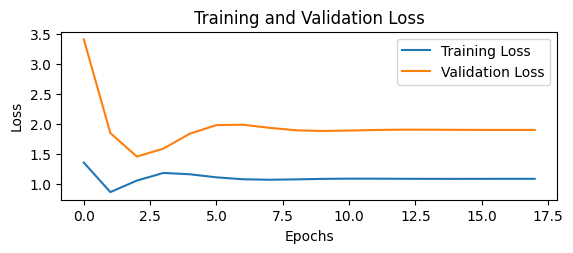

In [77]:
EPOCHS = 20
early_stop_patience = 15
early_stop_counter = 0

# Lists to store metrics
train_losses = []
val_losses = []
best_val_loss = float('inf')

for epoch in tqdm(range(EPOCHS)):
    # Training phase
    model_0.train()
    train_loss = 0.0
    for X_batch, y_batch in train_loader:
        # Forward pass
        outputs, _ = model_0(X_batch)
        loss = criterion(outputs, y_batch)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * X_batch.size(0)
    
    train_loss = train_loss / len(train_loader.dataset)
    train_losses.append(train_loss)
    
    # Validation phase
    model_0.eval()
    val_loss = 0.0
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            outputs, _ = model_0(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item() * X_batch.size(0)
            
            # Store predictions and targets for metrics
            all_preds.append(outputs.cpu().numpy())
            all_targets.append(y_batch.cpu().numpy())
    
    val_loss = val_loss / len(val_loader.dataset)
    val_losses.append(val_loss)
    
    # Calculate additional metrics for validation set
    all_preds = np.concatenate(all_preds)
    all_targets = np.concatenate(all_targets)
    rmse = np.sqrt(mean_squared_error(all_targets, all_preds))
    mae = mean_absolute_error(all_targets, all_preds)
    r2 = r2_score(all_targets, all_preds)
    
    # Print progress
    print(f"Epoch [{epoch+1}/{EPOCHS}], "
          f"Train Loss: {train_loss:.4f}, "
          f"Val Loss: {val_loss:.4f}, "
          f"RMSE: {rmse:.4f}, "
          f"MAE: {mae:.4f}, "
          f"R²: {r2:.4f}")
    
    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stop_counter = 0
        # Save the best model_0
        print(f"Model saved at epoch {epoch+1}")
    else:
        early_stop_counter += 1
        
    if early_stop_counter >= early_stop_patience:
        print(f"Early stopping triggered after {epoch+1} epochs")
        break

# Plot training and validation loss
plt.subplot(2, 1, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

In [78]:
model_0.eval()
all_predictions = []
all_actual = []

with torch.no_grad():  # No gradients needed for inference
    for X_batch, y_batch in val_loader:
        # Get predictions
        predictions, _ = model_0(X_batch)
        
        # Store predictions and actual values
        all_predictions.extend(predictions.cpu().numpy())
        all_actual.extend(y_batch.cpu().numpy())

# 5. Convert to numpy arrays for analysis
eval_predictions = np.array(all_predictions)
eval_actual = np.array(all_actual)

In [79]:
eval_predictions

array([[0.16998938],
       [0.16998938],
       [0.16998938],
       [0.16998938],
       [0.16998938],
       [0.16998938],
       [0.16998938],
       [0.16998938],
       [0.16998938]], dtype=float32)

Text(0.5, 1.0, 'Predictions vs Actual (Original Scale)')

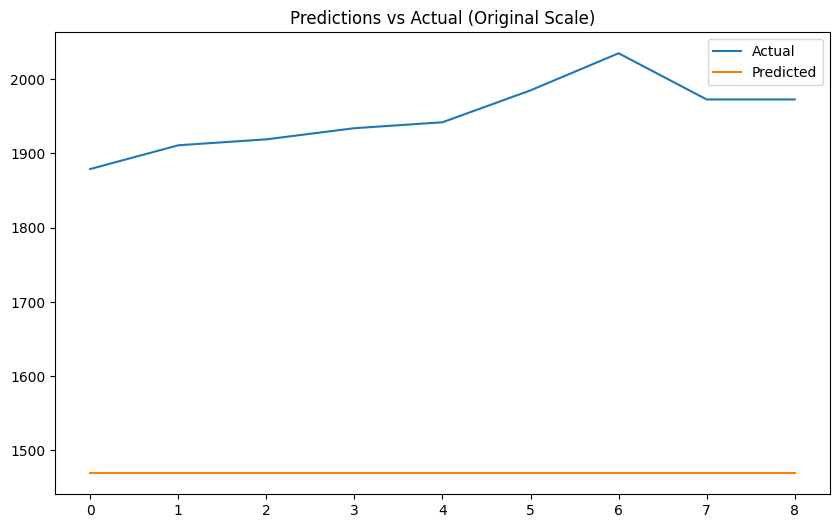

In [80]:
eval_predictions = scaler_target.inverse_transform(eval_predictions)
eval_actual = scaler_target.inverse_transform(eval_actual)

eval_predictions = np.expm1(eval_predictions)
eval_actual = np.expm1(eval_actual)

plt.figure(figsize=(10, 6))
plt.plot(eval_actual, label='Actual')
plt.plot(eval_predictions, label='Predicted')
plt.legend()
plt.title('Predictions vs Actual (Original Scale)')

In [81]:
class MonetaryLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0.2):
        super(MonetaryLSTM, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # RNN layers
        self.rnn = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )
        
        # Fully connected output layer
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, hidden_size//2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size//2, output_size)
        )
    
    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        # Forward propagate through RNN
        out, _ = self.rnn(x, (h0, c0))
        
        # Use only the output from the last time step
        out = out[:, -1, :]
        
        # Pass through the fully connected layer
        out = self.fc(out)
        return out

In [82]:
INPUT_SIZE = X_train.shape[2]
HIDDEN_SIZE = 128
NUM_LAYERS = 1
OUTPUT_SIZE = 1
DROPOUT = 0.2

model_1 = MonetaryLSTM(INPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS, OUTPUT_SIZE, DROPOUT)
model_1 = model_1.to(device)

model_1

MonetaryLSTM(
  (rnn): LSTM(4, 128, batch_first=True)
  (fc): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=64, out_features=1, bias=True)
  )
)

In [83]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model_1.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10, factor=0.5, verbose=True)

d:\File\Anaconda\envs\PT\lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


 45%|████▌     | 9/20 [00:00<00:00, 22.86it/s]

Epoch [5/20], Train Loss: 1.419633, Val Loss: 3.700895
Epoch [10/20], Train Loss: 1.418941, Val Loss: 3.565244


 90%|█████████ | 18/20 [00:00<00:00, 23.59it/s]

Epoch [15/20], Train Loss: 1.398953, Val Loss: 3.527245


100%|██████████| 20/20 [00:00<00:00, 23.54it/s]

Epoch [20/20], Train Loss: 1.403305, Val Loss: 3.513031


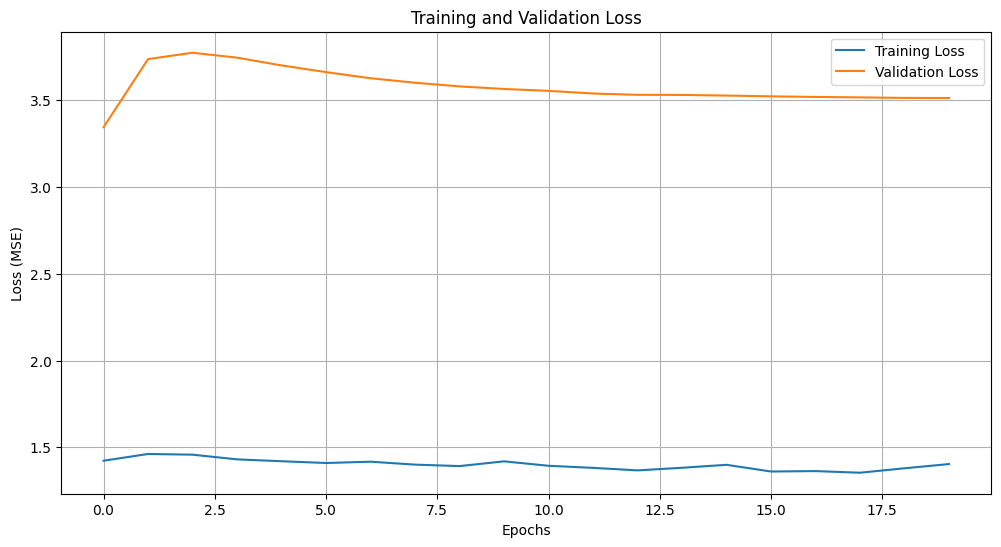

In [84]:
EPOCHS = 20

# Lists to store metrics
train_losses = []
val_losses = []
best_val_loss = float('inf')

# Training and evaluation loop
for epoch in tqdm(range(EPOCHS)):
    # Training phase
    model_1.train()
    train_loss = 0
    
    # Process batches using DataLoader
    for batch_X, batch_y in train_loader:
        # Forward pass
        outputs = model_1(batch_X)
        loss = criterion(outputs, batch_y)
        
        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        
        # Gradient clipping to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model_1.parameters(), max_norm=1.0)
        
        optimizer.step()
        
        train_loss += loss.item()
    
    # Calculate average training loss
    train_loss = train_loss / len(train_loader)
    train_losses.append(train_loss)
    
    # Validation phase
    model_1.eval()
    val_loss = 0
    
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            val_outputs = model_1(batch_X)
            batch_loss = criterion(val_outputs, batch_y)
            val_loss += batch_loss.item()
        
        # Calculate average validation loss
        val_loss = val_loss / len(val_loader)
        val_losses.append(val_loss)
        
        # Save best model_1
        if val_loss < best_val_loss:
            best_val_loss = val_loss
    
    # Adjust learning rate based on validation performance
    scheduler.step(val_loss)
    
    # Print progress
    if (epoch + 1) % 5 == 0:
        print(f'Epoch [{epoch+1}/{EPOCHS}], '
              f'Train Loss: {train_loss:.6f}, '
              f'Val Loss: {val_loss:.6f}')

# Visualization of training history
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()